<a href="https://colab.research.google.com/github/chrisliii/FINE-452/blob/main/M%26A_CAPM_FF3_Daily_Portfolio_BUD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modules

In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.5MB 6.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=d4d364853307c3f2e8b946aa732aac09c9213a221e74f6a29897367720064e72
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Prep

In [ ]:
#S&P500 - ^GSPC
stock_name = "STZ"
ticker = yf.Ticker(stock_name)
#ticker.info
# daily data
df_ticker_daily_return = ticker.history(period="max", interval='1d')
# process Dividends
df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
# daily return
#df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
df_ticker_daily_return = df_ticker_daily_return.dropna()
#date to string
df_ticker_daily_return = df_ticker_daily_return.reset_index()
df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))

df_ticker_daily_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyReturn
0,19920318,1.452155,1.490880,1.442474,1.490880,617600,0.0,0.0,4.054067
1,19920319,1.510241,1.529604,1.490879,1.519922,984000,0.0,0.0,1.948042
2,19920320,1.500560,1.539285,1.500560,1.539285,260000,0.0,0.0,1.273887
3,19920323,1.548965,1.578009,1.548965,1.548965,658400,0.0,0.0,0.628920
4,19920324,1.548965,1.616732,1.548965,1.587689,230400,0.0,0.0,2.499988


In [2]:
df_FF_Research = pd.read_csv('F-F_Research_Data_5_Factors_daily.CSV', encoding="utf-8", skipinitialspace=True, skiprows=3)
df_FF_Research.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
df_FF_Research = df_FF_Research.dropna()

#df_FF_Research['Date'] = df_FF_Research['Date'].shift(1)
#df_FF_Research['RF'] = df_FF_Research['RF'].shift(1)
#df_FF_Research = df_FF_Research.dropna()

df_FF_Research['Date'] = df_FF_Research['Date'].astype(str)
df_FF_Research['Mkt-RF'] = df_FF_Research['Mkt-RF'].astype(float)
df_FF_Research['SMB'] = df_FF_Research['SMB'].astype(float)
df_FF_Research['HML'] = df_FF_Research['HML'].astype(float)
df_FF_Research['RMW'] = df_FF_Research['RMW'].astype(float)
df_FF_Research['CMA'] = df_FF_Research['CMA'].astype(float)
df_FF_Research['RF'] = df_FF_Research['RF'].astype(float)

df_FF_Research.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.00,-0.32,-0.01,0.15,0.012
1,19630702,0.79,-0.27,0.27,-0.07,-0.19,0.012
2,19630703,0.63,-0.17,-0.09,0.17,-0.33,0.012
3,19630705,0.40,0.08,-0.28,0.08,-0.33,0.012
4,19630708,-0.63,0.04,-0.18,-0.29,0.13,0.012


### CAPM

#### CAPM Rolling Regression

In [ ]:
# past period rolling

# data prep
df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 9, 1)
#in days
sample_period = 1080

# CAPM out of sample
for sample_date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (sample_date - timedelta(days=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,DailyReturn,Mkt-RF,SMB,HML,RF,PredReturn
316,2010-10-01,44.969887,45.007938,44.216455,44.642639,606700,0.0,0,-0.727704,0.43,-0.06,0.21,0.001,0.377779
317,2010-10-04,43.912042,44.231678,43.615237,43.828327,575300,0.0,0,-0.190642,-0.88,-0.73,-0.04,0.001,-0.323757
318,2010-10-05,44.505658,45.228647,44.490437,45.129711,1171200,0.0,0,1.402188,2.11,0.77,0.16,0.001,1.268695
319,2010-10-06,45.342792,45.662427,45.091647,45.578712,639500,0.0,0,0.520305,-0.10,-0.39,0.43,0.001,0.092483
320,2010-10-07,45.692881,45.723324,44.992723,45.289528,1785300,0.0,0,-0.882749,-0.16,0.05,-0.27,0.001,0.061887


#### CAPM Cumulative Regression Function

In [ ]:
# past period accumulative

def CAPMCumulativeRegression(stock_name, begin_date):
  #stock data
  ticker = yf.Ticker(stock_name)
  #ticker.info
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # CAPM out of sample
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
    CAPM_result = CAPM_model.fit()
    #print(stock_name + '\n')
    #print (result.params)
    #print(CAPM_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input['Mkt-RF'].values[0]
    sample_pred =  CAPM_result.predict([1,sample_input])
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  df_ticker_FF = df_ticker_FF.dropna()

  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### Temp Code

In [ ]:
ticker = yf.Ticker('BUD')
df_portfolio_return_weight = ticker.history(period="max", interval='1mo').Close.to_frame()
df_portfolio_return_weight = df_portfolio_return_weight.dropna()
df_portfolio_return_weight = df_portfolio_return_weight.reset_index()
df_portfolio_return_weight.columns = ['Date', 'TAP'+'Weight']
df_portfolio_return_weight.tail(1)

,Date,TAPWeight
137,2020-11-10,66.599998


In [ ]:
stock_name_list = ['BUD', 'TAP']
for stock_name in stock_name_list:
  ticker = yf.Ticker(stock_name)
  df_single_stock = ticker.history(period="max", interval='1mo').Close.to_frame()
  df_single_stock = df_single_stock.dropna()
  df_single_stock = df_single_stock.reset_index()
  df_single_stock.columns = ['Date', stock_name+'Weight']
  if (stock_name == stock_name_list[0]):
    df_portfolio_weight = df_single_stock
  else:
    df_portfolio_weight = pd.merge(df_portfolio_weight, df_single_stock, on='Date')

df_portfolio_weight = df_portfolio_weight.set_index('Date')
df_portfolio_weight = df_portfolio_weight.div(df_portfolio_weight.sum(axis=1), axis=0)
df_portfolio_weight = df_portfolio_weight.reset_index()


df_portfolio_weight.head()
stock_name_list[1:]

['TAP']

In [ ]:
ticker = yf.Ticker('TAP')
    # daily data
df_ticker_daily_return = ticker.history(period="max", interval='1d')
    # process Dividends
df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
    # daily return
    #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
df_ticker_daily_return = df_ticker_daily_return.dropna()

df_ticker_daily_return = df_ticker_daily_return.reset_index()

df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
df_ticker_daily_return.columns = 

df_ticker_daily_return.head()



SyntaxError: ignored

In [ ]:
df_ticker_FF = CAPMCumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY'], begin_date)
df_ticker_FF.head()

,Date,TAPReturn,SAMReturn,KNBWYReturn,DailyReturn
0,1995-11-22,2.547808,4.910714,1.408515,2.955679
1,1995-11-24,0.931688,10.638298,0.000000,3.856662
2,1995-11-27,-0.923088,-6.923077,-1.388952,-3.078372
3,1995-11-28,7.207017,-3.305785,2.816932,2.239388
4,1995-11-29,0.300296,-2.991453,-1.940625,-1.543928


#### Regression on Portfolio

In [ ]:
# past period accumulative

def CAPMCumulativeRegressionPortfolio(stock_name_list, begin_date):
  #monthly price by stock
  for stock_name in stock_name_list:
    ticker = yf.Ticker(stock_name)
    df_single_stock = ticker.history(period="max", interval='1mo').Close.to_frame()
    df_single_stock = df_single_stock.dropna()
    df_single_stock = df_single_stock.reset_index()
    df_single_stock.columns = ['Date', stock_name+'Weight']
    if (stock_name == stock_name_list[0]):
      df_portfolio_weight = df_single_stock
    else:
      df_portfolio_weight = pd.merge(df_portfolio_weight, df_single_stock, on='Date')
  #weight
  df_portfolio_weight = df_portfolio_weight.set_index('Date')
  df_portfolio_weight = df_portfolio_weight.div(df_portfolio_weight.sum(axis=1), axis=0)
  df_portfolio_weight = df_portfolio_weight.reset_index()
  df_portfolio_weight['Month'] = df_portfolio_weight['Date'].apply(lambda x: x.strftime('%Y%m'))

  #stock return
  for stock_name in stock_name_list:
    ticker = yf.Ticker(stock_name)
    # daily data
    df_ticker_daily_return = ticker.history(period="max", interval='1d')
    # process Dividends
    df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
    # daily return
    #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
    df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
    df_ticker_daily_return = df_ticker_daily_return.dropna()
    df_ticker_daily_return = df_ticker_daily_return.reset_index()
    df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
    df_ticker_daily_return.columns = ['Date', stock_name+'Return']
    if (stock_name == stock_name_list[0]):
      df_portfolio_return = df_ticker_daily_return
    else:
      df_portfolio_return = pd.merge(df_portfolio_return, df_ticker_daily_return, on='Date')
    df_portfolio_return['Month'] = df_portfolio_return['Date'].apply(lambda x: x.strftime('%Y%m'))

  df_portfolio_return = pd.merge(df_portfolio_return, df_portfolio_weight, on='Month')
  df_portfolio_return['DailyReturn'] = df_portfolio_return[stock_name_list[0]+'Weight'] * df_portfolio_return[stock_name_list[0]+'Return']
  for stock_name in stock_name_list[1:]:
    df_portfolio_return['DailyReturn'] = df_portfolio_return['DailyReturn'] + df_portfolio_return[stock_name+'Weight'] * df_portfolio_return[stock_name+'Return']

  return df_portfolio_return

  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # CAPM out of sample
  for sample_date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
    CAPM_result = CAPM_model.fit()
    #print(stock_name + '\n')
    #print (result.params)
    #print(CAPM_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input['Mkt-RF'].values[0]
    sample_pred =  CAPM_result.predict([1,sample_input])
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  df_ticker_FF = df_ticker_FF.dropna()

  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### Regression on Portfolio (updated)

In [ ]:
# past period accumulative

def CAPMCumulativeRegressionPortfolio(stock_name_list, begin_date):

  #stock return
  for stock_name in stock_name_list:
    ticker = yf.Ticker(stock_name)
    # daily data
    df_ticker_daily_return = ticker.history(period="max", interval='1d')
    # process Dividends
    df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
    # daily return
    #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
    df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
    df_ticker_daily_return = df_ticker_daily_return.dropna()
    df_ticker_daily_return = df_ticker_daily_return.reset_index()
    df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
    df_ticker_daily_return.columns = ['Date', stock_name+'Return']
    if (stock_name == stock_name_list[0]):
      df_portfolio_return = df_ticker_daily_return
    else:
      df_portfolio_return = pd.merge(df_portfolio_return, df_ticker_daily_return, on='Date')

  df_portfolio_return = df_portfolio_return.set_index('Date')
  df_portfolio_return["DailyReturn"] = df_portfolio_return.sum(axis=1)
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return['DailyReturn'] = df_portfolio_return['DailyReturn'] / len(stock_name_list)

  #return df_portfolio_return

  df_ticker_daily_return = df_portfolio_return

  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # CAPM out of sample
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    CAPM_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
    CAPM_result = CAPM_model.fit()
    #print(stock_name + '\n')
    #print (result.params)
    #print(CAPM_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input['Mkt-RF'].values[0]
    sample_pred =  CAPM_result.predict([1,sample_input])
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  df_ticker_FF = df_ticker_FF.dropna()

  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### CAPM Epsilon

#### CAPM Plot 6 subplots

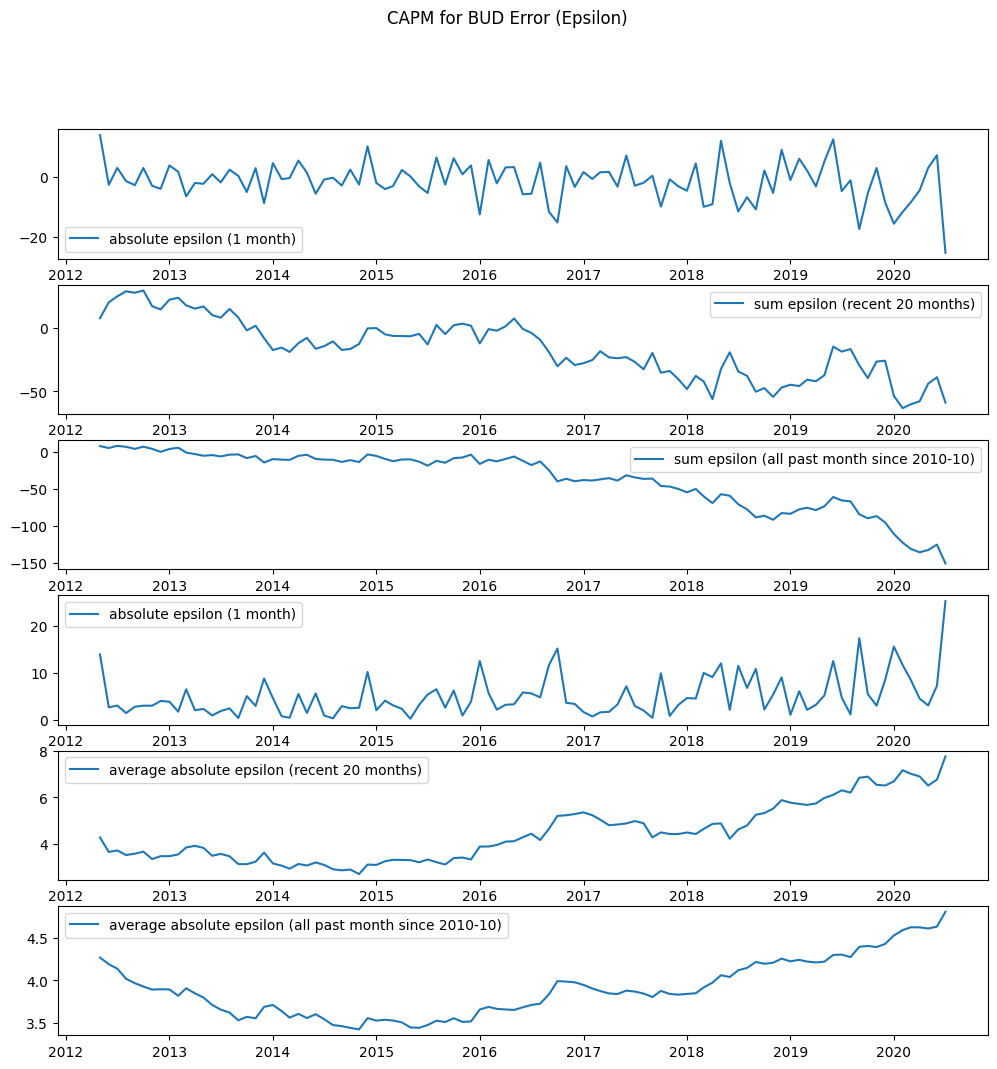

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('CAPM for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### CAPM Plot 3 subplots

In [ ]:
df_ticker_FF.Date

1552   2015-09-01
1553   2015-09-02
1554   2015-09-03
1555   2015-09-04
1556   2015-09-08
          ...    
1905   2017-01-26
1906   2017-01-27
1907   2017-01-30
1908   2017-01-31
1909   2017-02-01
Name: Date, Length: 358, dtype: datetime64[ns]

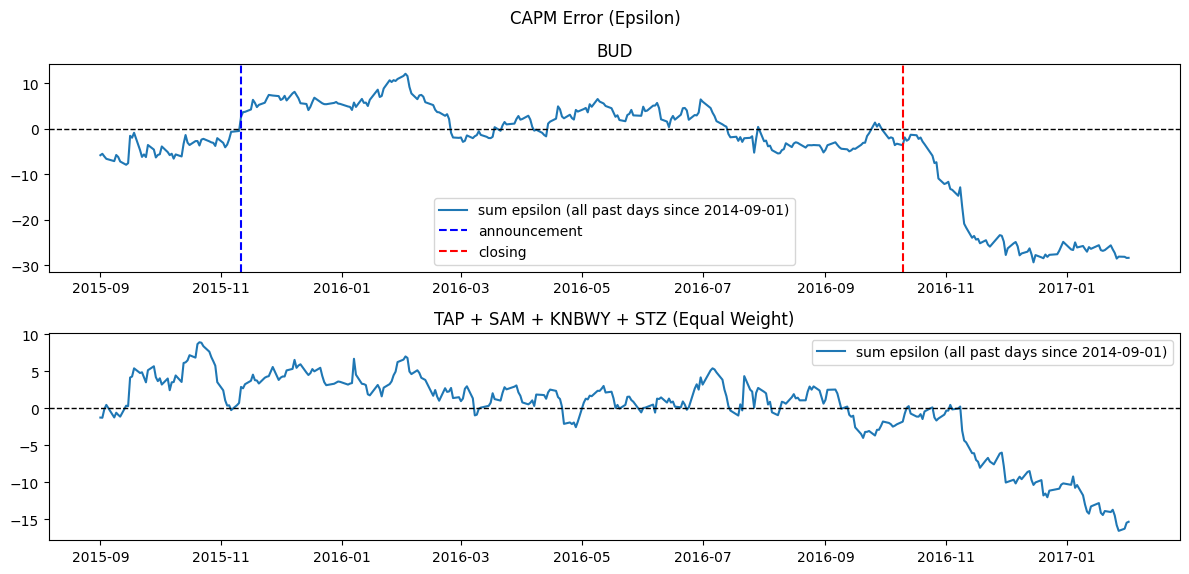

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, dpi=100, figsize=(12,6))
fig.suptitle('CAPM Error (Epsilon)')

begin_date = datetime(2014, 9, 1)
begin_date_label = '2014-09-01'

#BUD
df_ticker_FF = CAPMCumulativeRegression('BUD', begin_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='announcement')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='closing')
ax1.title.set_text('BUD')
ax1.legend()

#Portfolio
df_ticker_FF = CAPMCumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('TAP + SAM + KNBWY + STZ (Equal Weight)')
ax2.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### FF3

#### FF3 Cumulative Regression

In [ ]:
# past period accumulative

def FF3CumulativeRegression(stock_name, begin_date):
  #stock data
  ticker = yf.Ticker(stock_name)
  #ticker.info
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # FF3 out of sample
  sample_date = begin_date
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    FF3_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], 
                        sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML']].values))
    FF3_result = FF3_model.fit()
    #print(stock_name + '\n')
    #print (FF3_result.params)
    #print(FF3_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input[['Mkt-RF', 'SMB', 'HML']].values[0].tolist()
    sample_pred =  FF3_result.predict([1] + sample_input)
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### Regression on Portfolio (updated)


In [ ]:
def FF3CumulativeRegressionPortfolio(stock_name_list, begin_date):
  #stock return
  for stock_name in stock_name_list:
    ticker = yf.Ticker(stock_name)
    # daily data
    df_ticker_daily_return = ticker.history(period="max", interval='1d')
    # process Dividends
    df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
    # daily return
    #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
    df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
    df_ticker_daily_return = df_ticker_daily_return.dropna()
    df_ticker_daily_return = df_ticker_daily_return.reset_index()
    df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
    df_ticker_daily_return.columns = ['Date', stock_name+'Return']
    if (stock_name == stock_name_list[0]):
      df_portfolio_return = df_ticker_daily_return
    else:
      df_portfolio_return = pd.merge(df_portfolio_return, df_ticker_daily_return, on='Date')

  df_portfolio_return = df_portfolio_return.set_index('Date')
  df_portfolio_return["DailyReturn"] = df_portfolio_return.sum(axis=1)
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return['DailyReturn'] = df_portfolio_return['DailyReturn'] / len(stock_name_list)

  #return df_portfolio_return

  df_ticker_daily_return = df_portfolio_return

  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # FF3 out of sample
  sample_date = begin_date
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    FF3_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], 
                        sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML']].values))
    FF3_result = FF3_model.fit()
    #print(stock_name + '\n')
    #print (FF3_result.params)
    #print(FF3_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input[['Mkt-RF', 'SMB', 'HML']].values[0].tolist()
    sample_pred =  FF3_result.predict([1] + sample_input)
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### FF3 Epsilon

#### FF3 Plot 6 subplots

NameError: ignored

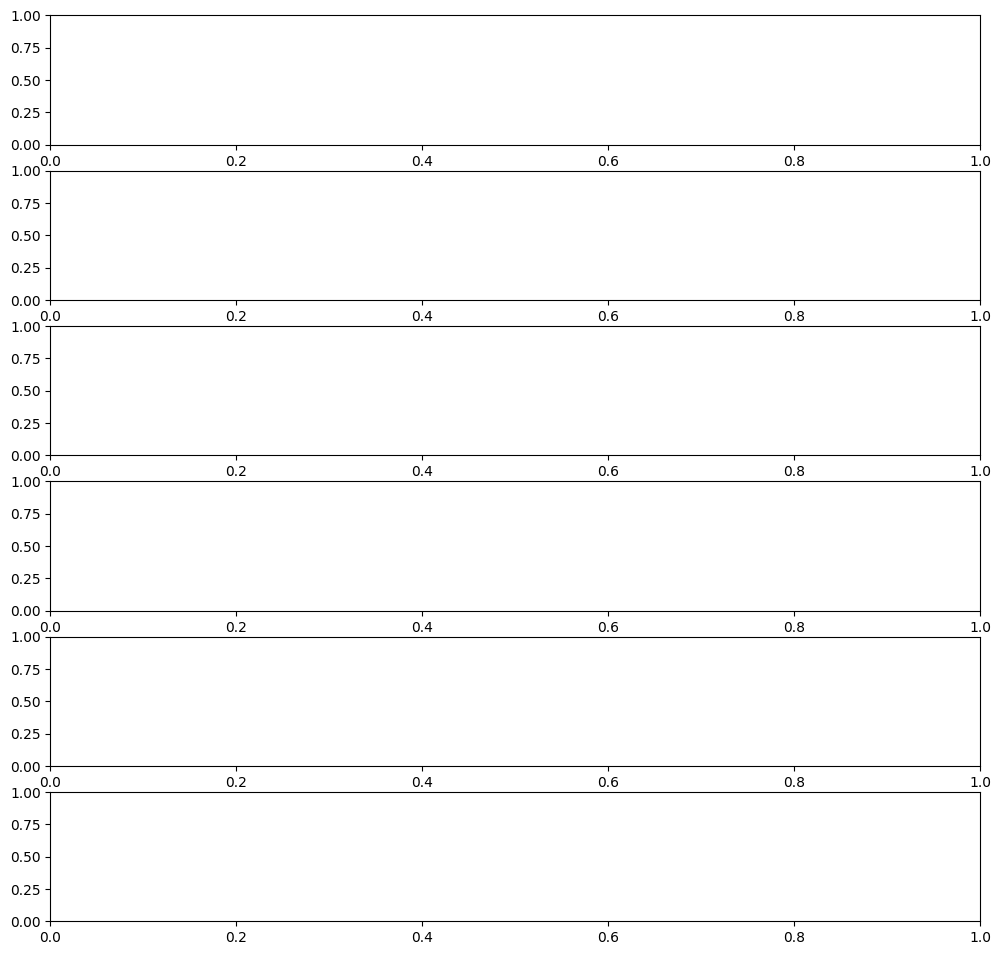

In [ ]:
df_ticker_FF = df_ticker_FF.dropna()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, dpi=100, figsize=(12,12))
fig.suptitle('FF3 for '+ stock_name +' Error (Epsilon)')
ax1.plot(df_ticker_FF.Date, df_ticker_FF.Epsilon, label='absolute epsilon (1 month)')
ax1.legend()
ax2.plot(df_ticker_FF.Date, df_ticker_FF.RollingSumEpsilon, label='sum epsilon (recent 20 months)')
ax2.legend()
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past month since 2010-10)')
ax3.legend()
ax4.plot(df_ticker_FF.Date, df_ticker_FF.AbsEpsilon, label='absolute epsilon (1 month)')
ax4.legend()
ax5.plot(df_ticker_FF.Date, df_ticker_FF.RollingAvgAbsEpsilon, label='average absolute epsilon (recent 20 months)')
ax5.legend()
ax6.plot(df_ticker_FF.Date, df_ticker_FF.CumAvgAbsEpsilon, label='average absolute epsilon (all past month since 2010-10)')
ax6.legend()

#### FF3 Plot 3 subplots

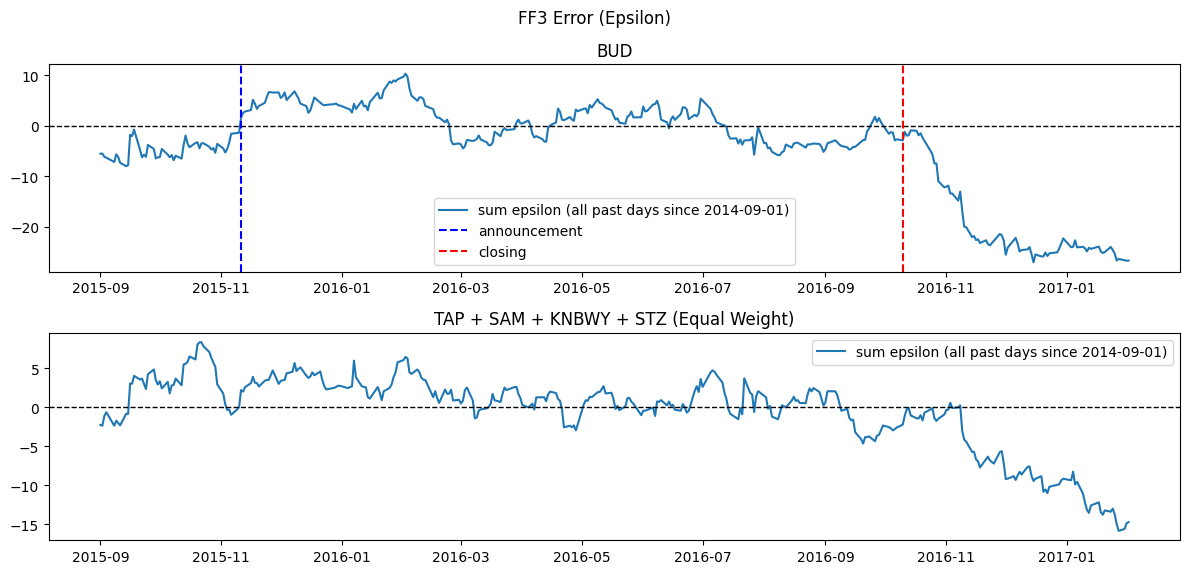

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, dpi=100, figsize=(12,6))
fig.suptitle('FF3 Error (Epsilon)')

begin_date = datetime(2014, 9, 1)
begin_date_label = '2014-09-01'

#BUD
df_ticker_FF = FF3CumulativeRegression('BUD', begin_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='announcement')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='closing')
ax1.title.set_text('BUD')
ax1.legend()

#Portfolio
df_ticker_FF = FF3CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('TAP + SAM + KNBWY + STZ (Equal Weight)')
ax2.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### FF5

#### FF5 Cumulative Regression

In [3]:
# past period accumulative

def FF5CumulativeRegression(stock_name, begin_date, end_date):
  #stock data
  ticker = yf.Ticker(stock_name)
  #ticker.info
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  #end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # FF5 out of sample
  sample_date = begin_date
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    FF3_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], 
                        sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values))
    FF3_result = FF3_model.fit()
    #print(stock_name + '\n')
    #print (FF3_result.params)
    #print(FF3_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values[0].tolist()
    sample_pred =  FF3_result.predict([1] + sample_input)
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  #df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  #df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  #df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  #for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  #  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### Regression on Portfolio (updated)

In [4]:
def FF5CumulativeRegressionPortfolio(stock_name_list, begin_date, end_date):
  #stock return
  for stock_name in stock_name_list:
    ticker = yf.Ticker(stock_name)
    # daily data
    df_ticker_daily_return = ticker.history(period="max", interval='1d')
    # process Dividends
    df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
    # daily return
    #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
    df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
    df_ticker_daily_return = df_ticker_daily_return.dropna()
    df_ticker_daily_return = df_ticker_daily_return.reset_index()
    df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
    df_ticker_daily_return.columns = ['Date', stock_name+'Return']
    if (stock_name == stock_name_list[0]):
      df_portfolio_return = df_ticker_daily_return
    else:
      df_portfolio_return = pd.merge(df_portfolio_return, df_ticker_daily_return, on='Date')

  df_portfolio_return = df_portfolio_return.set_index('Date')
  df_portfolio_return["DailyReturn"] = df_portfolio_return.sum(axis=1)
  df_portfolio_return = df_portfolio_return.reset_index()
  df_portfolio_return['DailyReturn'] = df_portfolio_return['DailyReturn'] / len(stock_name_list)

  #return df_portfolio_return

  df_ticker_daily_return = df_portfolio_return

  #date to string
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
  # data prep
  df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
  df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

  # sample period
  #begin_date = datetime(2010, 10, 1)
  #end_date = datetime(2017, 2, 1)
  # in days
  sample_period = 1825

  # FF5 out of sample
  sample_date = begin_date
  for sample_date in df_ticker_FF[(df_ticker_FF.Date >= begin_date) & (df_ticker_FF.Date <= end_date)].Date.tolist():
    df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (begin_date - timedelta(days=sample_period)) ) & 
                                      (df_ticker_FF.Date < sample_date)].copy()
    FF3_model = sm.OLS(df_ticker_FF_sample['DailyReturn'], 
                        sm.add_constant(df_ticker_FF_sample[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values))
    FF3_result = FF3_model.fit()
    #print(stock_name + '\n')
    #print (FF3_result.params)
    #print(FF3_result.summary())

    # predict 
    sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
    sample_input = sample_input[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values[0].tolist()
    sample_pred =  FF3_result.predict([1] + sample_input)
    #print(sample_input)
    #print(sample_pred)
    df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]


  # Epsilon
  df_ticker_FF['Epsilon'] = df_ticker_FF.DailyReturn - df_ticker_FF.RF - df_ticker_FF.PredReturn
  # RollingSumEpsilon
  #df_ticker_FF['RollingSumEpsilon'] = df_ticker_FF.Epsilon.rolling(30).sum()
  # CumSumEpsilon
  for date in df_ticker_FF[df_ticker_FF.Date >= begin_date].Date.tolist():
    df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumSumEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].Epsilon.sum()
  # AbsEpsilon
  #df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF['Epsilon'])
  # RollingAvgAbsEpsilon
  #df_ticker_FF['RollingAvgAbsEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(30).mean()
  # CumAvgAbsEpsilon
  #for date in df_ticker_FF[df_ticker_FF.Date >= begin_date + relativedelta(months=12)].Date.tolist():
  #  df_ticker_FF.loc[df_ticker_FF.Date == date, 'CumAvgAbsEpsilon'] = df_ticker_FF[df_ticker_FF.Date <= date].AbsEpsilon.mean()

  df_ticker_FF = df_ticker_FF.dropna()

  return df_ticker_FF

#### Plot

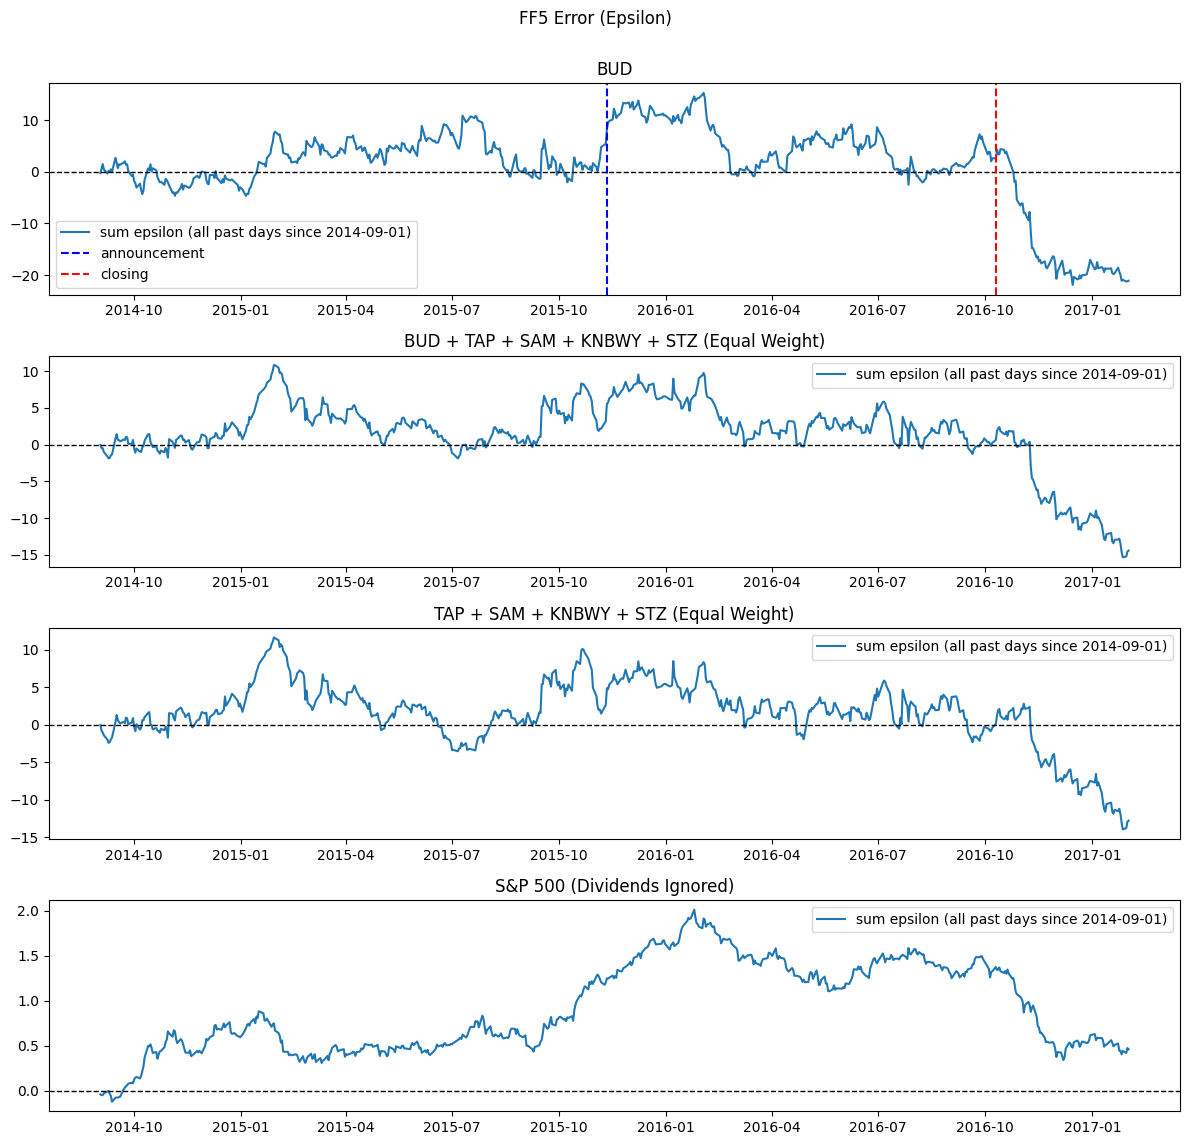

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, dpi=100, figsize=(12,12))
fig.suptitle('FF5 Error (Epsilon)')

begin_date = datetime(2014, 9, 1)
end_date = datetime(2017, 2, 1)
begin_date_label = '2014-09-01'

#BUD
df_ticker_FF = FF5CumulativeRegression('BUD', begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='announcement')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='closing')
ax1.title.set_text('BUD')
ax1.legend()

#Portfolio with BUD
df_ticker_FF = FF5CumulativeRegressionPortfolio(['BUD', 'TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('BUD + TAP + SAM + KNBWY + STZ (Equal Weight)')
ax2.legend()

#Portfolio without BUD
df_ticker_FF = FF5CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
ax3.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax3.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax3.title.set_text('TAP + SAM + KNBWY + STZ (Equal Weight)')
ax3.legend()

#S&P 500
df_ticker_FF = FF5CumulativeRegression('^GSPC', begin_date, end_date)
ax4.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (all past days since {})'.format(begin_date_label))
ax4.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax4.title.set_text('S&P 500 (Dividends Ignored)')
ax4.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

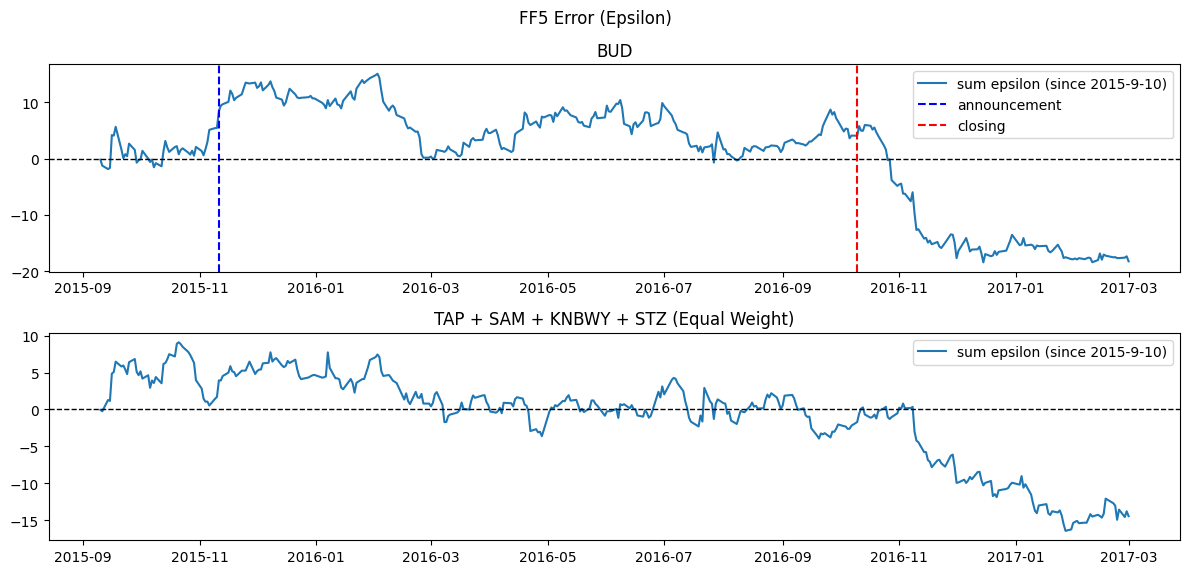

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, dpi=100, figsize=(12,6))
fig.suptitle('FF5 Sum Error (Epsilon)')

begin_date = datetime(2015, 9, 10)
end_date = datetime(2017, 3, 1)
begin_date_label = '2015-9-10'

#BUD
df_ticker_FF = FF5CumulativeRegression('BUD', begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (since {})'.format(begin_date_label))
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='announcement')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='closing')
ax1.title.set_text('BUD')
ax1.legend()

#Portfolio without BUD
df_ticker_FF = FF5CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='sum epsilon (since {})'.format(begin_date_label))
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.title.set_text('TAP + SAM + KNBWY + STZ (Equal Weight)')
ax2.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

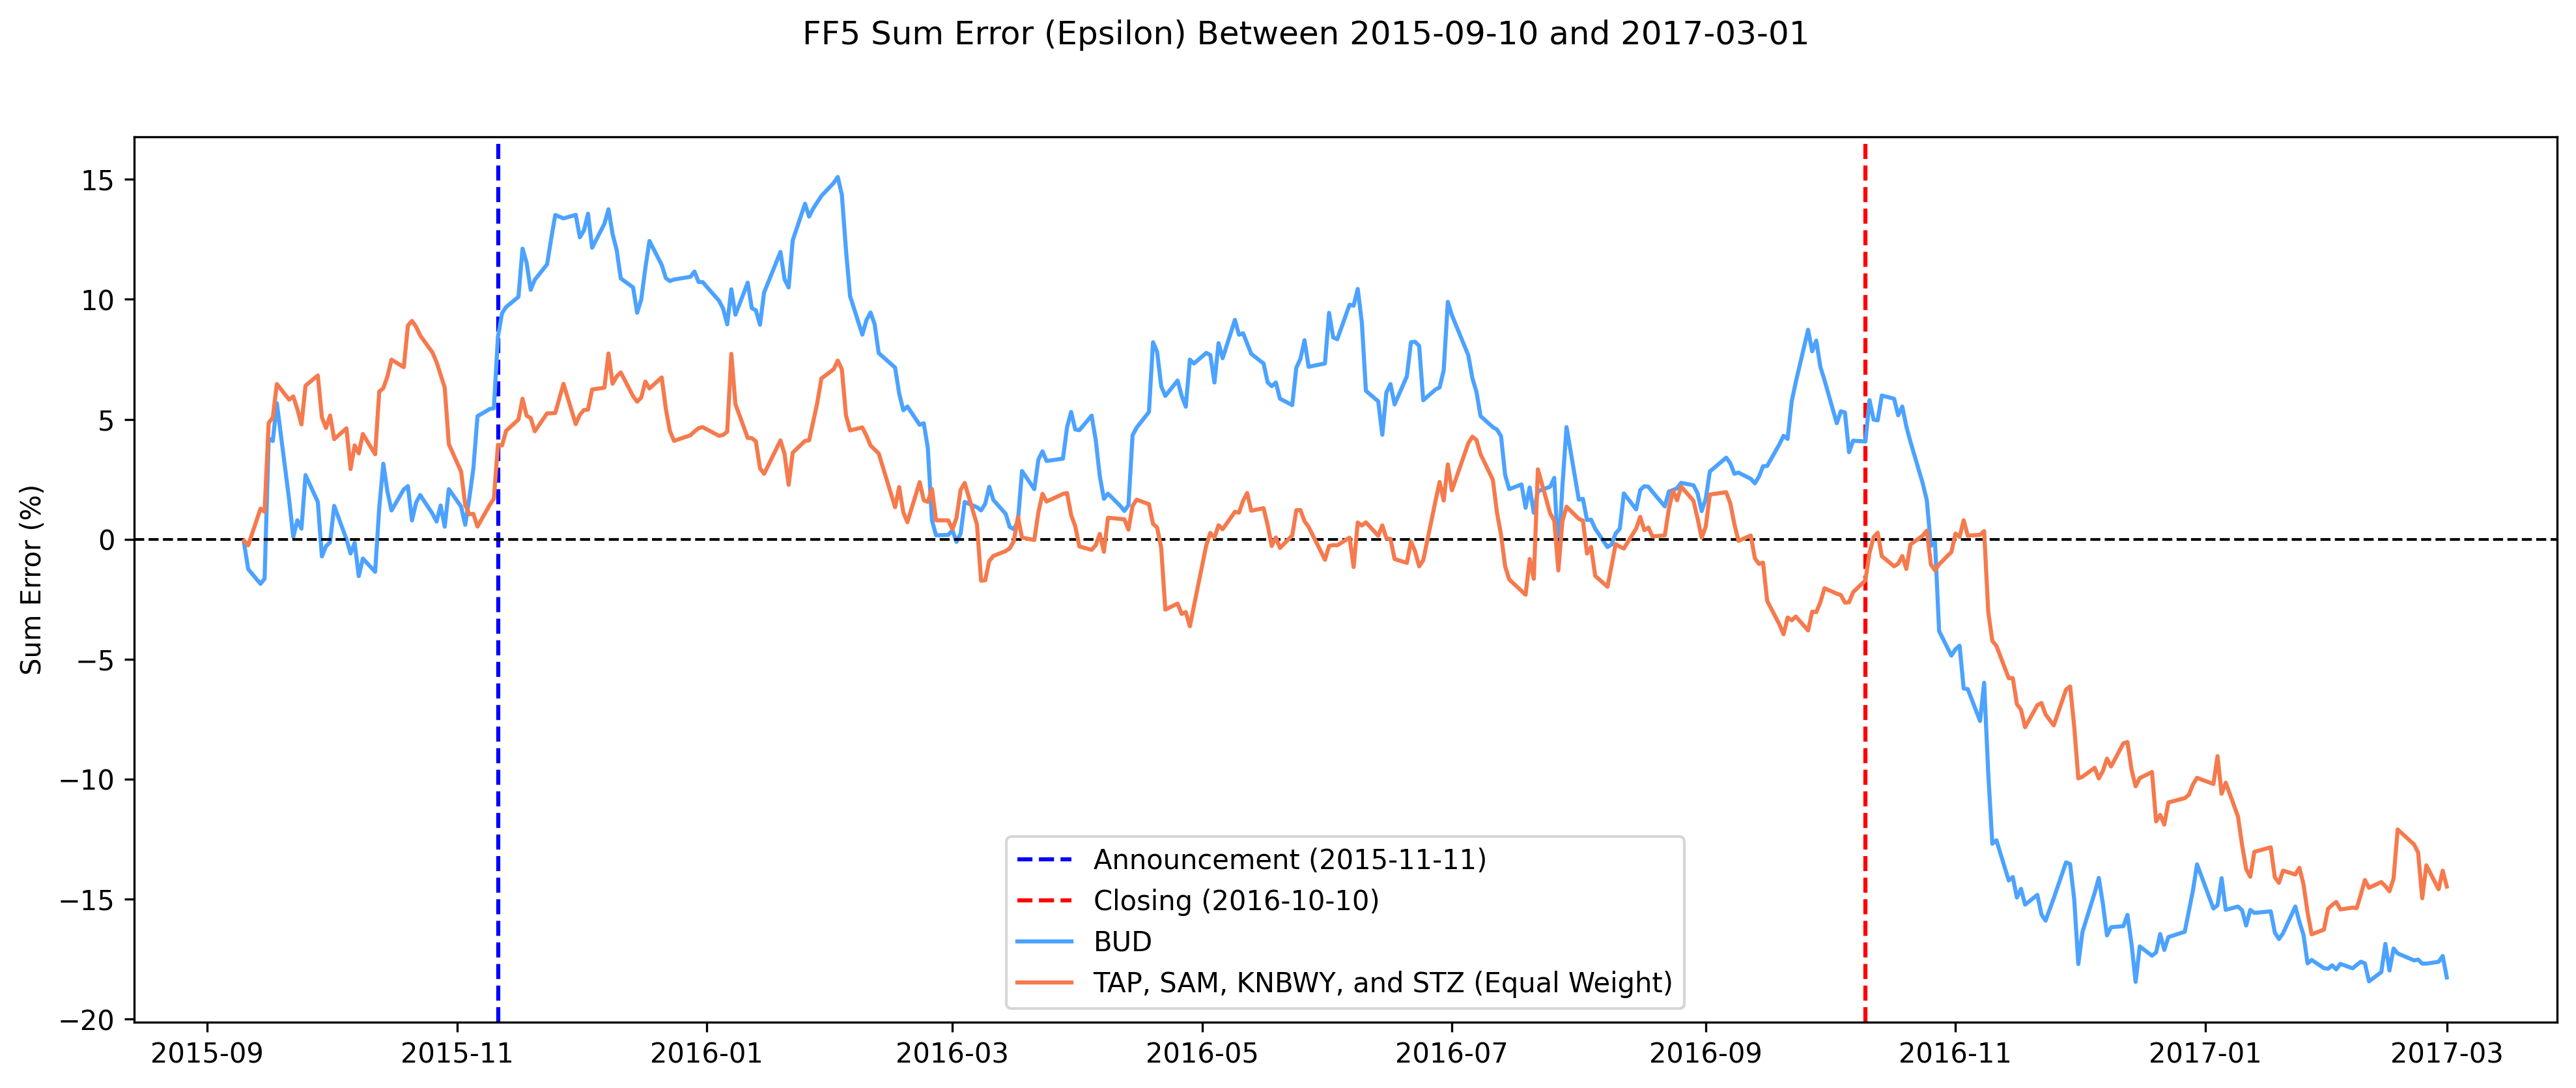

In [ ]:
fig, (ax1) = plt.subplots(1, dpi=300, figsize=(16,6))
fig.suptitle('FF5 Sum Error (Epsilon) Between 2015-09-10 and 2017-03-01')

begin_date = datetime(2015, 9, 10)
end_date = datetime(2017, 3, 1)
begin_date_label = '2015-9-10'

ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='Announcement (2015-11-11)')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='Closing (2016-10-10)')

#BUD
df_ticker_FF = FF5CumulativeRegression('BUD', begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='BUD', color='#4ca2ff')
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')

#Portfolio without BUD
df_ticker_FF = FF5CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.CumSumEpsilon, label='TAP, SAM, KNBWY, and STZ (Equal Weight)', color='#F57A4D')
#FBBC58

ax1.set_ylabel('Sum Error (%)')
ax1.legend()

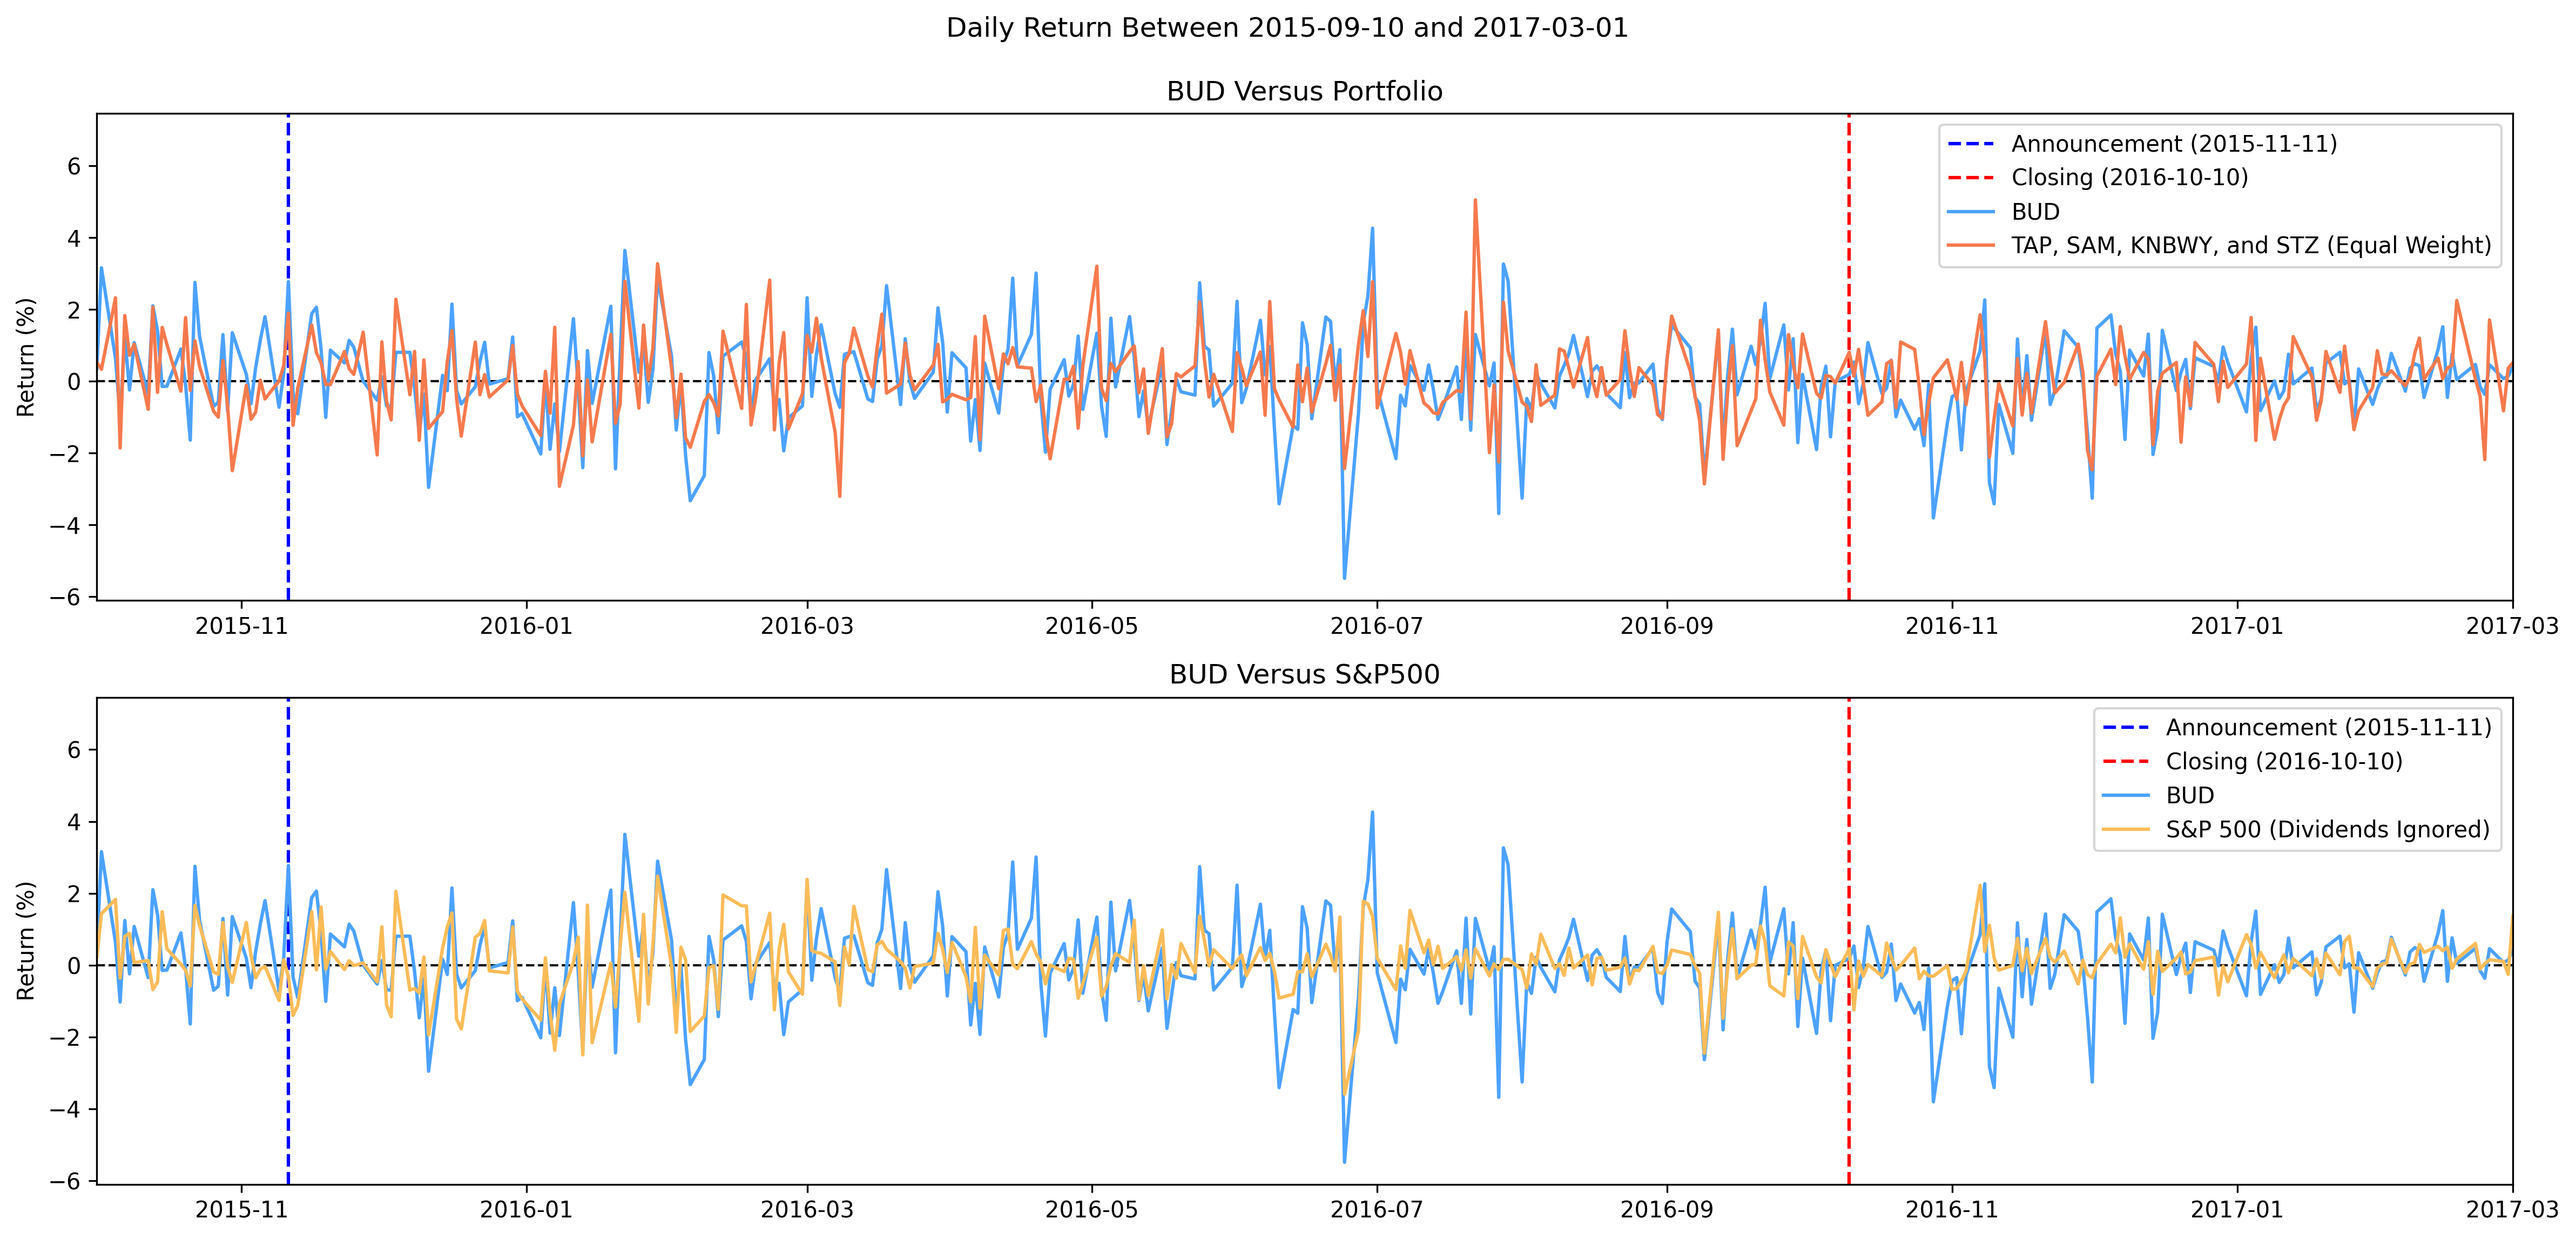

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, dpi=300, figsize=(16,8))
fig.suptitle('Daily Return Between 2015-09-10 and 2017-03-01')

begin_date = datetime(2015, 9, 10)
end_date = datetime(2017, 3, 1)
begin_date_label = '2015-9-10'

ax1.title.set_text('BUD Versus Portfolio')
ax1.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax1.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='Announcement (2015-11-11)')
ax1.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='Closing (2016-10-10)')
#GIS
df_ticker_FF = FF5CumulativeRegression('BUD', begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.DailyReturn, label='BUD', color='#4ca2ff')
#Portfolio without BUD
df_ticker_FF = FF5CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
ax1.plot(df_ticker_FF.Date, df_ticker_FF.DailyReturn, label='TAP, SAM, KNBWY, and STZ (Equal Weight)', color='#F57A4D')

ax1.set_ylabel('Return (%)')
ax1.legend()
ax1.set_xlim([datetime(2015, 10, 1), end_date])

ax2.title.set_text('BUD Versus S&P500')
ax2.axhline(y=0, linewidth=1, color='black', linestyle='--')
ax2.axvline(x=datetime(2015,11,11), color='blue', linestyle='--', label='Announcement (2015-11-11)')
ax2.axvline(x=datetime(2016,10,10), color='red', linestyle='--', label='Closing (2016-10-10)')
#GIS
df_ticker_FF = FF5CumulativeRegression('BUD', begin_date, end_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.DailyReturn, label='BUD', color='#4ca2ff')
#S&P 500
df_ticker_FF = FF5CumulativeRegression('^GSPC', begin_date, end_date)
ax2.plot(df_ticker_FF.Date, df_ticker_FF.DailyReturn, label='S&P 500 (Dividends Ignored)', color='#FBBC58')

ax2.set_ylabel('Return (%)')
ax2.legend()
ax2.set_xlim([datetime(2015, 10, 1), end_date])


fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
#stock data
ticker = yf.Ticker("BUD")
#ticker.info
# daily data
df_ticker_daily_return = ticker.history(period="max", interval='1d')
# process Dividends
df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
# daily return
#df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
df_ticker_daily_return = df_ticker_daily_return.dropna()
#date to string
df_ticker_daily_return = df_ticker_daily_return.reset_index()
df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
# data prep
df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= datetime(2010, 1, 1)) & (df_ticker_FF.Date <= datetime(2020, 1, 1))]

# CAPM out of sample
print('CAPM')
CAPM_model = sm.OLS(df_ticker_FF['DailyReturn'], sm.add_constant(df_ticker_FF[['Mkt-RF']].values))
CAPM_result = CAPM_model.fit()
#print(stock_name + '\n')
#print (result.params)
print(CAPM_result.summary())

print('FF3')
FF3_model = sm.OLS(df_ticker_FF['DailyReturn'],
                   sm.add_constant(df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
FF3_result = FF3_model.fit()
#print(stock_name + '\n')
#print (FF3_result.params)
print(FF3_result.summary())

print('FF5')
FF5_model = sm.OLS(df_ticker_FF['DailyReturn'],
                   sm.add_constant(df_ticker_FF[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values))
FF5_result = FF5_model.fit()
#print(stock_name + '\n')
#print (FF3_result.params)
print(FF5_result.summary())

CAPM
                            OLS Regression Results                            
Dep. Variable:            DailyReturn   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     1192.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          4.41e-214
Time:                        01:21:55   Log-Likelihood:                -3983.5
No. Observations:                2516   AIC:                             7971.
Df Residuals:                    2514   BIC:                             7983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.024      0.287    

In [ ]:
#stock return
stock_name_list = ['TAP', 'SAM', 'KNBWY', 'STZ']
for stock_name in stock_name_list:
  ticker = yf.Ticker(stock_name)
  # daily data
  df_ticker_daily_return = ticker.history(period="max", interval='1d')
  # process Dividends
  df_ticker_daily_return = df_ticker_daily_return.dropna(how='all')
  # daily return
  #df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Open']) - 1)
  df_ticker_daily_return['DailyReturn'] = 100*( (df_ticker_daily_return['Close']+df_ticker_daily_return['Dividends']).div(df_ticker_daily_return['Close'].shift(1)) - 1)
  df_ticker_daily_return = df_ticker_daily_return.dropna()
  df_ticker_daily_return = df_ticker_daily_return.reset_index()
  df_ticker_daily_return = df_ticker_daily_return[['Date','DailyReturn']]
  df_ticker_daily_return.columns = ['Date', stock_name+'Return']
  if (stock_name == stock_name_list[0]):
    df_portfolio_return = df_ticker_daily_return
  else:
    df_portfolio_return = pd.merge(df_portfolio_return, df_ticker_daily_return, on='Date')

df_portfolio_return = df_portfolio_return.set_index('Date')
df_portfolio_return["DailyReturn"] = df_portfolio_return.sum(axis=1)
df_portfolio_return = df_portfolio_return.reset_index()
df_portfolio_return['DailyReturn'] = df_portfolio_return['DailyReturn'] / len(stock_name_list)

#return df_portfolio_return

df_ticker_daily_return = df_portfolio_return

#date to string
df_ticker_daily_return = df_ticker_daily_return.reset_index()
df_ticker_daily_return['Date'] = df_ticker_daily_return['Date'].apply(lambda x: x.strftime('%Y%m%d'))
# data prep
df_ticker_FF = pd.merge(df_ticker_daily_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m%d')

df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= datetime(2010, 1, 1)) & (df_ticker_FF.Date <= datetime(2020, 1, 1))]

# CAPM out of sample
print('CAPM')
CAPM_model = sm.OLS(df_ticker_FF['DailyReturn'], sm.add_constant(df_ticker_FF[['Mkt-RF']].values))
CAPM_result = CAPM_model.fit()
#print(stock_name + '\n')
#print (result.params)
print(CAPM_result.summary())

print('FF3')
FF3_model = sm.OLS(df_ticker_FF['DailyReturn'],
                   sm.add_constant(df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
FF3_result = FF3_model.fit()
#print(stock_name + '\n')
#print (FF3_result.params)
print(FF3_result.summary())

print('FF5')
FF5_model = sm.OLS(df_ticker_FF['DailyReturn'],
                   sm.add_constant(df_ticker_FF[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values))
FF5_result = FF5_model.fit()
#print(stock_name + '\n')
#print (FF3_result.params)
print(FF5_result.summary())

CAPM
                            OLS Regression Results                            
Dep. Variable:            DailyReturn   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1619.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          1.20e-273
Time:                        01:24:07   Log-Likelihood:                -3191.4
No. Observations:                2516   AIC:                             6387.
Df Residuals:                    2514   BIC:                             6399.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0378      0.017      2.202    

In [6]:
begin_date = datetime(2015, 9, 10)
end_date = datetime(2017, 3, 1)

#BUD
df_ticker_FF_event = FF5CumulativeRegression('BUD', begin_date, end_date)
df_ticker_FF_event = df_ticker_FF_event[['Date','DailyReturn','Epsilon','CumSumEpsilon']]
df_ticker_FF_event.columns = ['Date','Event_DailyReturn','Event_Epsilon','Event_CumSumEpsilon']

#Portfolio without BUD
df_ticker_FF_portfolio = FF5CumulativeRegressionPortfolio(['TAP', 'SAM', 'KNBWY', 'STZ'], begin_date, end_date)
df_ticker_FF_portfolio = df_ticker_FF_portfolio[['Date','DailyReturn','Epsilon','CumSumEpsilon']]
df_ticker_FF_portfolio.columns = ['Date','Portfolio_DailyReturn','Portfolio_Epsilon','Portfolio_CumSumEpsilon']

df_output = df_ticker_FF_event.merge(df_ticker_FF_portfolio, on='Date')
df_output.head()

df_output.to_csv('BUD_versus_portfolio.csv')